# Meridional Overturning

`mom6_tools.moc` functions for computing and plotting meridional overturning. 

The goal of this notebook is the following:

1) server as an example on to compute a meridional overturning streamfunction (global and Atalntic) from CESM/MOM output; 

2) evaluate model experiments by comparing transports against observed estimates and other model results.


In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import xarray as xr
# mom6_tools
from mom6_tools.moc import  *
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.m6toolbox import request_workers, genBasinMasks, add_global_attrs 
import matplotlib.pyplot as plt
import warnings, yaml
warnings.filterwarnings("ignore")

Basemap module not found. Some regional plots may not function properly


In [2]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])
RUNDIR = dcase.get_value('RUNDIR')
print('Run directory is:', RUNDIR)
print('Casename is:', dcase.casename)

Run directory is: /glade/scratch/gmarques/g.c2b6.GJRA.TL319_t061.long_JRA_mct.025/run
Casename is: g.c2b6.GJRA.TL319_t061.long_JRA_mct.025


In [3]:
# The following parameters must be set accordingly
######################################################
# add your name and email address below
author = 'Gustavo Marques (gmarques@ucar.edu)'
######################################################
# create an empty class object
class args:
  pass
   
args.infile = RUNDIR
args.monthly = dcase.casename+'.mom6.h_*nc'
args.sigma2 = dcase.casename+'.mom6.rho2_*nc'
args.start_date = ''
args.end_date = ''
args.case_name = dcase.casename
args.label = ''
args.savefigs = False

In [4]:
# set avg dates
avg = diag_config_yml['Avg']
if not args.start_date : args.start_date = avg['start_date']
if not args.end_date : args.end_date = avg['end_date']

In [5]:
# Load the grid
grd = dcase.grid
depth = grd.depth_ocean
# remove Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, verbose=False)

MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


In [6]:
parallel, cluster, client = m6toolbox.request_workers(6)

Requesting 6 workers... 

/proxy/38758/status


In [7]:
client

Client Scheduler: tcp://128.117.181.227:35309 Dashboard: /proxy/38758/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [8]:
def preprocess(ds):
    variables = ['vmo','vhml','vhGM']
    for v in variables:
      if v not in ds.variables:
        ds[v] = xr.zeros_like(ds.vo)
    return ds[variables]

In [9]:
print('\n Reading dataset...')
# load data
%time ds = xr.open_mfdataset(RUNDIR+'/'+dcase.casename+'.mom6.h_*.nc', parallel=True, \
                             combine="nested", concat_dim="time", preprocess=preprocess).chunk({"time": 12})


 Reading dataset...
CPU times: user 531 ms, sys: 91.8 ms, total: 623 ms
Wall time: 8.32 s


In [10]:
# compute yearly means first since this will be used in the time series
print('\n Computing yearly means...')
%time ds_yr = ds.resample(time="1Y", closed='left').mean('time')


 Computing yearly means...
CPU times: user 430 ms, sys: 7.54 ms, total: 437 ms
Wall time: 479 ms


In [11]:
print('\n Selecting data between {} and {}...'.format(args.start_date, args.end_date))
%time ds_sel = ds_yr.sel(time=slice(args.start_date, args.end_date))


 Selecting data between 0029-01-01 and 0059-01-01...
CPU times: user 6.89 ms, sys: 91 µs, total: 6.98 ms
Wall time: 6.24 ms


In [12]:
print('\n Computing time mean...')
%time ds_mean = ds_sel.mean('time').compute()


 Computing time mean...
CPU times: user 1.01 s, sys: 315 ms, total: 1.33 s
Wall time: 18.3 s


In [13]:
stream = True
# create a ndarray subclass
class C(numpy.ndarray): pass

if 'vmo' in ds.variables:
  varName = 'vmo'; conversion_factor = 1.e-9
elif 'vh' in ds.variables:
  varName = 'vh'; conversion_factor = 1.e-6
  if 'zw' in ds.variables: conversion_factor = 1.e-9 # Backwards compatible for when we had wrong units for 'vh'
else: raise Exception('Could not find "vh" or "vmo" in file "%s"'%(args.infile+args.static))
  

tmp = np.ma.masked_invalid(ds_mean[varName].values)
tmp = tmp[:].filled(0.)
VHmod = tmp.view(C)
VHmod.units = ds[varName].units


Zmod = m6toolbox.get_z(ds, depth, varName)

if args.case_name != '':  case_name = args.case_name + ' ' + args.label
else: case_name = rootGroup.title + ' ' + args.label


## Global MOC

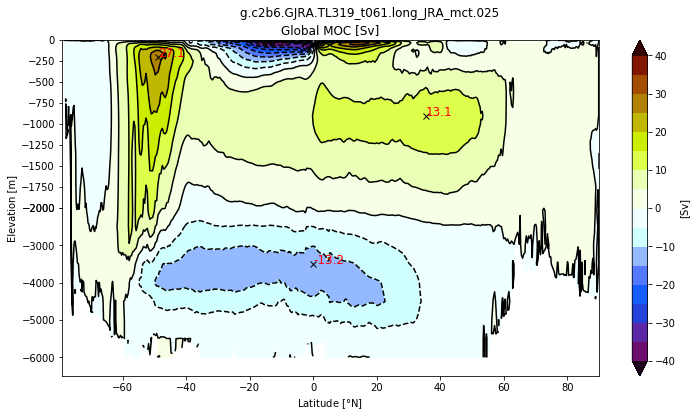

In [14]:
%matplotlib inline

# Global MOC
m6plot.setFigureSize([16,9],576,debug=False)
axis = plt.gca()
cmap = plt.get_cmap('dunnePM')
zg = Zmod.min(axis=-1); psiPlot = MOCpsi(VHmod)*conversion_factor
psiPlot = 0.5 * (psiPlot[0:-1,:]+psiPlot[1::,:])
yyg = grd.geolat_c[:,:].max(axis=-1)+0*zg

ci=m6plot.pmCI(0.,40.,5.)
plotPsi(yyg, zg, psiPlot, ci, 'Global MOC [Sv]')
plt.xlabel(r'Latitude [$\degree$N]')
plt.suptitle(case_name)
plt.gca().invert_yaxis()
findExtrema(yyg, zg, psiPlot, max_lat=-30.)
findExtrema(yyg, zg, psiPlot, min_lat=25., min_depth=250.)
findExtrema(yyg, zg, psiPlot, min_depth=2000., mult=-1.)

In [15]:
# create dataset to store results
moc = xr.Dataset(data_vars={ 'moc' :    (('z_l','yq'), psiPlot),
                            'amoc' :   (('z_l','yq'), np.zeros((psiPlot.shape))),
                            'moc_FFM' :   (('z_l','yq'), np.zeros((psiPlot.shape))),
                            'moc_GM' : (('z_l','yq'), np.zeros((psiPlot.shape))),
                            'amoc_45' : (('time'), np.zeros((ds_yr.time.shape))),
                            'moc_GM_ACC' : (('time'), np.zeros((ds_yr.time.shape))),
                            'amoc_26' : (('time'), np.zeros((ds_yr.time.shape))) },
                            coords={'z_l': ds.z_l, 'yq':ds.yq, 'time':ds_yr.time})
attrs = {'description': 'MOC time-mean sections and time-series', 'unit': 'Sv', 'start_date': avg['start_date'],
       'end_date': avg['end_date']}
add_global_attrs(moc,attrs)

## Atlantic MOC

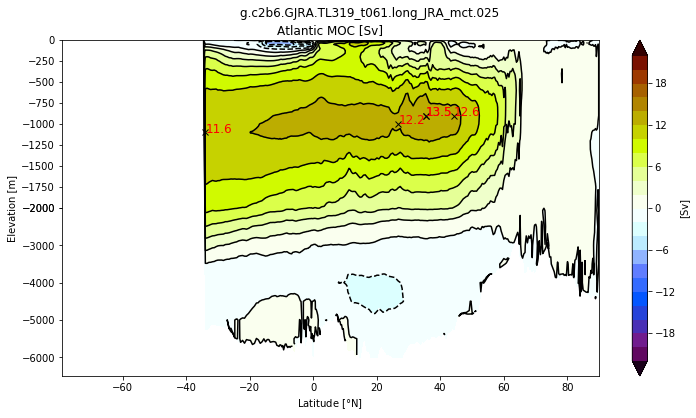

In [16]:
m6plot.setFigureSize([16,9],576,debug=False)
cmap = plt.get_cmap('dunnePM')
m = 0*basin_code; m[(basin_code==2) | (basin_code==4) | (basin_code==6) | (basin_code==7) | (basin_code==8)]=1
ci=m6plot.pmCI(0.,22.,2.)
z = (m*Zmod).min(axis=-1); psiPlot = MOCpsi(VHmod, vmsk=m*numpy.roll(m,-1,axis=-2))*conversion_factor
psiPlot = 0.5 * (psiPlot[0:-1,:]+psiPlot[1::,:])
yy = grd.geolat_c[:,:].max(axis=-1)+0*z
plotPsi(yy, z, psiPlot, ci, 'Atlantic MOC [Sv]')
plt.xlabel(r'Latitude [$\degree$N]')
plt.suptitle(case_name)
plt.gca().invert_yaxis()
findExtrema(yy, z, psiPlot, min_lat=26.5, max_lat=27., min_depth=250.) # RAPID
findExtrema(yy, z, psiPlot, min_lat=44, max_lat=46., min_depth=250.) # RAPID
findExtrema(yy, z, psiPlot, max_lat=-33.)
findExtrema(yy, z, psiPlot)
findExtrema(yy, z, psiPlot, min_lat=5.)
moc['amoc'].data = psiPlot

### AMOC profile at 26N

In [17]:
rapid_vertical = xr.open_dataset('/glade/work/gmarques/cesm/datasets/RAPID/moc_vertical.nc')

In [18]:
if 'zl' in ds:
  zl=ds.zl.values
elif 'z_l' in ds:
  zl=ds.z_l.values
else:
  raise ValueError("Dataset does not have vertical coordinate zl or z_l")

Text(0, 0.5, 'Depth [m]')

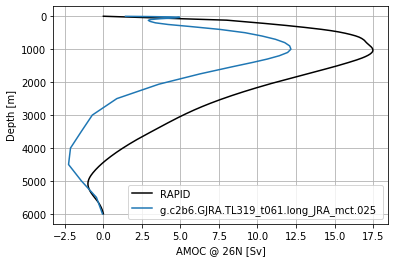

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(rapid_vertical.stream_function_mar.mean('time'), rapid_vertical.depth, 'k', label='RAPID')
ax.plot(moc['amoc'].sel(yq=26, method='nearest'), moc.z_l, label=case_name)
ax.legend()
plt.gca().invert_yaxis()
plt.grid()
ax.set_xlabel('AMOC @ 26N [Sv]')
ax.set_ylabel('Depth [m]')

## AMOC time series

In [20]:
dtime = ds_yr.time.values

amoc_26 = np.zeros(len(dtime))
amoc_45 = np.zeros(len(dtime))
moc_GM_ACC = numpy.zeros(len(dtime))

# loop in time
for t in range(len(dtime)):
    tmp = np.ma.masked_invalid(ds_yr[varName].sel(time=dtime[t]).values)
    tmp = tmp[:].filled(0.)
    psi = MOCpsi(tmp, vmsk=m*numpy.roll(m,-1,axis=-2))*conversion_factor
    psi = 0.5 * (psi[0:-1,:]+psi[1::,:])
    amoc_26[t] = findExtrema(yy, z, psi, min_lat=26.5, max_lat=27., plot=False)
    amoc_45[t] = findExtrema(yy, z, psi, min_lat=44., max_lat=46., plot=False)
    tmp_GM = numpy.ma.masked_invalid(ds_yr['vhGM'][t,:].values)
    tmp_GM = tmp_GM[:].filled(0.)
    psiGM = MOCpsi(tmp_GM)*conversion_factor
    psiGM = 0.5 * (psiGM[0:-1,:]+psiGM[1::,:])
    moc_GM_ACC[t] = findExtrema(yyg, zg, psiGM, min_lat=-65., max_lat=-30, mult=-1., plot=False)

In [21]:
# add dataarays to the moc dataset
moc['amoc_26'].data = amoc_26
moc['amoc_45'].data = amoc_45
moc['moc_GM_ACC'].data = moc_GM_ACC

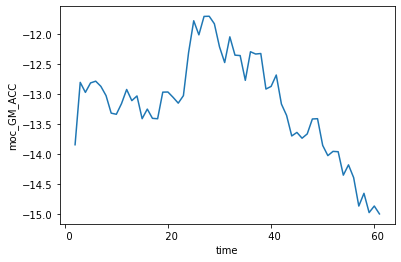

In [22]:
moc['moc_GM_ACC'].plot()

### AMOC @ 26 $^o$ N

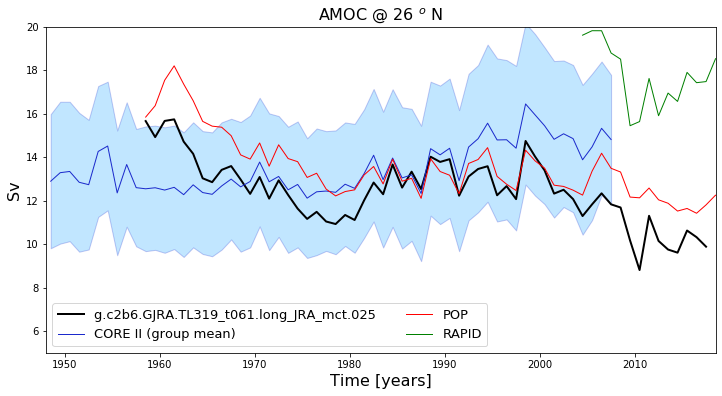

In [23]:
# load AMOC time series data (5th) cycle used in Danabasoglu et al., doi:10.1016/j.ocemod.2015.11.007
path = '/glade/p/cesm/omwg/amoc/COREII_AMOC_papers/papers/COREII.variability/data.original/'
amoc_core_26 = xr.open_dataset(path+'AMOCts.cyc5.26p5.nc')
# load AMOC from POP JRA-55
amoc_pop_26 = xr.open_dataset('/glade/u/home/bryan/MOM6-modeloutputanalysis/'
                              'AMOC_series_26n.g210.GIAF_JRA.v13.gx1v7.01.nc') 
# load RAPID time series
rapid = xr.open_dataset('/glade/work/gmarques/cesm/datasets/RAPID/moc_transports.nc').resample(time="1Y", 
                            closed='left',keep_attrs=True).mean('time',keep_attrs=True)

# plot
fig = plt.figure(figsize=(12, 6))
plt.plot(numpy.arange(len(moc.time))+1958.5 ,moc['amoc_26'].values, color='k', label=case_name, lw=2)
# core data
core_mean = amoc_core_26['MOC'].mean(axis=0).data
core_std = amoc_core_26['MOC'].std(axis=0).data
plt.plot(amoc_core_26.time,core_mean, 'k', label='CORE II (group mean)', color='#1B2ACC', lw=1)
plt.fill_between(amoc_core_26.time, core_mean-core_std, core_mean+core_std,
  alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')
# pop data
plt.plot(numpy.arange(len(amoc_pop_26.time))+1958.5 ,amoc_pop_26.AMOC_26n.values, color='r', label='POP', lw=1)
# rapid
plt.plot(numpy.arange(len(rapid.time))+2004.5 ,rapid.moc_mar_hc10.values, color='green', label='RAPID', lw=1)

plt.title('AMOC @ 26 $^o$ N', fontsize=16)
plt.ylim(5,20)
plt.xlim(1948,1958.5+len(moc.time))
plt.xlabel('Time [years]', fontsize=16); plt.ylabel('Sv', fontsize=16)
plt.legend(fontsize=13, ncol=2)

### AMOC @ 45 $^o$ N

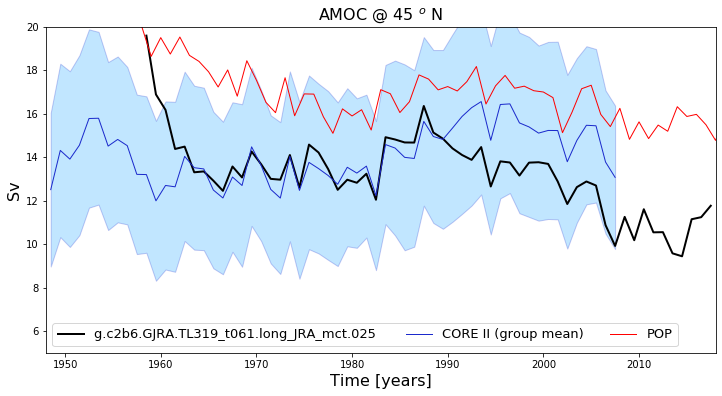

In [24]:
amoc_core_45 = xr.open_dataset(path+'AMOCts.cyc5.45.nc')
amoc_pop_45 = xr.open_dataset('/glade/u/home/bryan/MOM6-modeloutputanalysis/'
                              'AMOC_series_45n.g210.GIAF_JRA.v13.gx1v7.01.nc')

# plot
fig = plt.figure(figsize=(12, 6))
plt.plot(numpy.arange(len(moc.time))+1958.5 ,moc['amoc_45'].values, color='k', label=case_name, lw=2)
# core data
core_mean = amoc_core_45['MOC'].mean(axis=0).data
core_std = amoc_core_45['MOC'].std(axis=0).data
plt.plot(amoc_core_45.time,core_mean, 'k', label='CORE II (group mean)', color='#1B2ACC', lw=1)
plt.fill_between(amoc_core_45.time, core_mean-core_std, core_mean+core_std,
  alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')
# pop data
plt.plot(numpy.arange(len(amoc_pop_45.time))+1958. ,amoc_pop_45.AMOC_45n.values, color='r', label='POP', lw=1)

plt.title('AMOC @ 45 $^o$ N', fontsize=16)
plt.ylim(5,20)
plt.xlim(1948,1958+len(moc.time))
plt.xlabel('Time [years]', fontsize=16); plt.ylabel('Sv', fontsize=16)
plt.legend(fontsize=13, ncol=3)

### Submesoscale-induced Global MOC

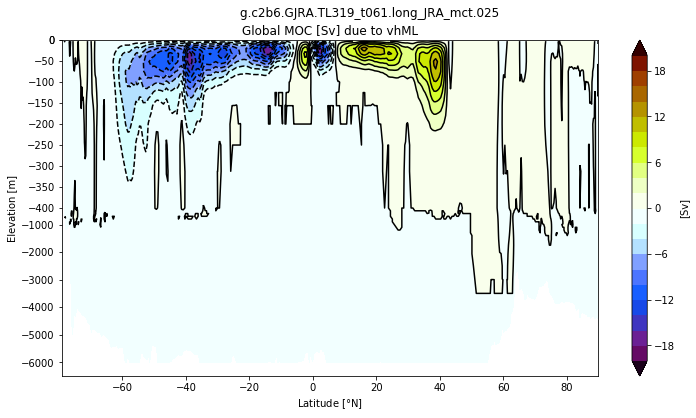

In [25]:
# create a ndarray subclass
class C(numpy.ndarray): pass

if 'vhml' in ds.variables:
  varName = 'vhml'; conversion_factor = 1.e-9
else: raise Exception('Could not find "vhml" in file "%s"'%(args.infile+args.monthly))
  
tmp = np.ma.masked_invalid(ds_mean[varName].values)
tmp = tmp[:].filled(0.)
VHmod = tmp.view(C)
VHmod.units = ds[varName].units

# Global MOC
m6plot.setFigureSize([16,9],576,debug=False)
axis = plt.gca()
cmap = plt.get_cmap('dunnePM')
z = Zmod.min(axis=-1); psiPlot = MOCpsi(VHmod)*conversion_factor
psiPlot = 0.5 * (psiPlot[0:-1,:]+psiPlot[1::,:])
#yy = y[1:,:].max(axis=-1)+0*z
yy = grd.geolat_c[:,:].max(axis=-1)+0*z
ci=m6plot.pmCI(0.,20.,2.)
plotPsi(yy, z, psiPlot, ci, 'Global MOC [Sv] due to vhML', zval=[0.,-400.,-6500.])
plt.xlabel(r'Latitude [$\degree$N]')
plt.suptitle(case_name)
plt.gca().invert_yaxis()
moc['moc_FFM'].data = psiPlot

### Eddy(GM)-induced Global MOC

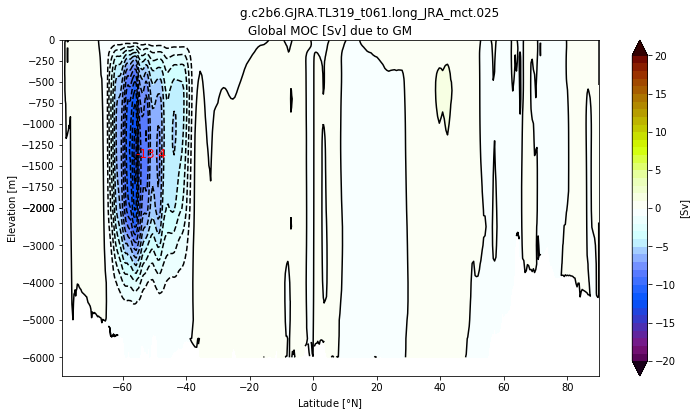

In [26]:
# create a ndarray subclass
class C(numpy.ndarray): pass

if 'vhGM' in ds.variables:
  varName = 'vhGM'; conversion_factor = 1.e-9
else: raise Exception('Could not find "vhGM" in file "%s"'%(args.infile+args.monthly))
  
tmp = np.ma.masked_invalid(ds_mean[varName].values)
tmp = tmp[:].filled(0.)
VHmod = tmp.view(C)
VHmod.units = ds[varName].units

# Global MOC
m6plot.setFigureSize([16,9],576,debug=False)
axis = plt.gca()
cmap = plt.get_cmap('dunnePM')
z = Zmod.min(axis=-1); psiPlot = MOCpsi(VHmod)*conversion_factor
psiPlot = 0.5 * (psiPlot[0:-1,:]+psiPlot[1::,:])
yy = grd.geolat_c[:,:].max(axis=-1)+0*z
ci=m6plot.pmCI(0.,20.,1.)
plotPsi(yy, z, psiPlot, ci, 'Global MOC [Sv] due to GM')
plt.xlabel(r'Latitude [$\degree$N]')
plt.suptitle(case_name)
findExtrema(yy, z, psiPlot, min_lat=-65., max_lat=-30, mult=-1.)
plt.gca().invert_yaxis()
moc['moc_GM'].data = psiPlot

### Sigma-2 space (to be implemented...)

In [ ]:
# load data
ds = xr.open_mfdataset(args.infile+args.sigma2,decode_times=False)

# create a ndarray subclass
class C(numpy.ndarray): pass

if 'vmo' in ds.variables:
  varName = 'vmo'; conversion_factor = 1.e-9
elif 'vh' in ds.variables:
  varName = 'vh'; conversion_factor = 1.e-6
  if 'zw' in ds.variables: conversion_factor = 1.e-9 # Backwards compatible for when we had wrong units for 'vh'
else: raise Exception('Could not find "vh" or "vmo" in file "%s"'%(args.infile+args.static))
  

tmp = np.ma.masked_invalid(ds[varName].sel(time=slice(ti,tf)).mean('time').data)
tmp = tmp[:].filled(0.)
VHmod = tmp.view(C)
VHmod.units = ds[varName].units


Zmod = m6toolbox.get_z(ds, depth, varName)

if args.case_name != '':  case_name = args.case_name + ' ' + args.label
else: case_name = rootGroup.title + ' ' + args.label

In [28]:
# release workers
client.close(); cluster.close()